**Корректность проверена на Python 3.7:**
+ numpy 1.18.1
+ scipy 1.4.1
+ matplotlib 3.1.3
+ sklearn 0.22.1

In [1]:
from time import time
import numpy as np
import random
import scipy 
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from functions import *
%matplotlib inline

# Анализ данных 

In [2]:
data = np.loadtxt("task3.txt")

In [3]:
data

array([[0.842713 , 0.171253 , 0.228401 , ..., 0.       , 0.       ,
        0.       ],
       [0.213799 , 0.0453138, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.791006 , 0.160917 , 0.105361 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.143809 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.0189764,
        0.       ]])

In [4]:
print(data[data==0].size, data.shape[0] * data.shape[1])

231996 345728


Значимых данных слишком мало
Попробуем узнать оптимальную размерность признаков посредством анализа дисперсии данных вдоль главных компонент

0.1216614815508505 1


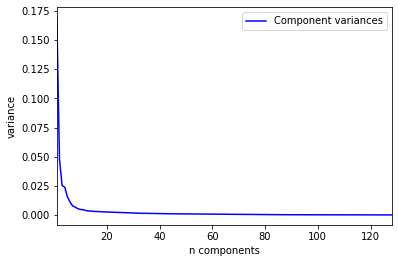

In [5]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score as cv_score

def plot_variances(d_variances):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('variance')
    plt.legend(loc='upper right')
    plt.show()

model = PCA(n_components=data.shape[1])
model.fit(data)
model.transform(data)
Var = np.sort(model.explained_variance_)[::-1]
Var_div = np.array([Var[i] - Var[i+1] for i in range(Var.size - 1)])
print(Var_div.max(), Var_div.argmax() + 1)
plot_variances(Var)

Информация в данных слишком избыточна, учитывая анализ дисперсии и здравый смысл, оптимальная размерность данных - 6

## Построение модели

Для моделирования пропущенных значений будем использовать матричные разложения с оптимизацией ALS, т.к. стохастический градиентный спуск слишком долго обучается на больших данных

** Вспомогательная фунция для поиска минимума, используя условие Armijo–Goldstein **

In [6]:
def search_gamma(func, P, c1, c2):
    n = 0
    gamma = c2 * (c1 ** n)
    P1 = P - gamma * func(P)[1]
    while func(P1)[0] >= func(P)[0] + np.vdot(func(P)[1], (P1-P)) + 1. / ( 2 * gamma) * (np.linalg.norm(P1-P) ** 2) :
        n += 1
        gamma = c2 * (c1 ** n)
        P1 = P - gamma * func(P)[1]
    return c2 * (c1 ** (n-1))


def grad_line_search(func, P0, epsilon): 
    P = P0
    max_iter = 0
    gamma = 0.5
    while (np.linalg.norm(func(P)[1]) > epsilon and max_iter < 300):
        c2 = gamma
        gamma = search_gamma(func ,P, 0.5, 0.5)
        P = P - gamma * func(P)[1]
        max_iter += 1
    return P, max_iter 

** ALS  **

In [7]:
def ALS(P0, Q0, rho, eps, max_iter):
    Q = Q0
    P = P0
    k = 0
    
    val, grad_P = objective_P(P0, Q0, data, rho)
    _, grad_Q = objective_Q(P0, Q0, data, rho)
    
    list_obj = []
    list_norm_P = []
    list_norm_Q = []

    list_obj.append(val)
    list_norm_P.append(np.linalg.norm(grad_P))
    list_norm_Q.append(np.linalg.norm(grad_Q))
    
    while (np.linalg.norm(grad_P) > eps or np.linalg.norm(grad_Q) > eps) and k < max_iter:
        
        P, _ = grad_line_search(lambda P : objective_P(P, Q, data, rho), P, eps)
        Q, _ = grad_line_search(lambda Q : objective_Q(P, Q, data, rho), Q, eps)
        
        val, grad_P = objective_P(P, Q, data, rho)
        _, grad_Q = objective_Q(P, Q, data, rho)
        k += 1
        
        list_obj.append(val)
        list_norm_P.append(np.linalg.norm(grad_P))
        list_norm_Q.append(np.linalg.norm(grad_Q))
        
        if k == 1 or k % 10 == 0:
            print("iteration = %d"%k)
            print("Norm of grad_P = %0.5f "%np.linalg.norm(grad_P))
            print("Norm of grad_Q = %0.5f "%np.linalg.norm(grad_Q))

    return P, Q, max_iter, list_obj, list_norm_P, list_norm_Q

** Задание параметров**

In [8]:
rho = 0.2
C = 6 
U,S,Vt = scipy.sparse.linalg.svds(data, k=6) 
eps = .1 
max_iter = 300 

P, Q, n, list_obj, list_norm_P, list_norm_Q = ALS(Vt, U, rho, eps, max_iter)

iteration = 1
Norm of grad_P = 7.74596 
Norm of grad_Q = 0.09810 
iteration = 10
Norm of grad_P = 3.93327 
Norm of grad_Q = 0.08303 
iteration = 20
Norm of grad_P = 2.78312 
Norm of grad_Q = 0.06970 
iteration = 30
Norm of grad_P = 2.19497 
Norm of grad_Q = 0.04496 
iteration = 40
Norm of grad_P = 1.75896 
Norm of grad_Q = 0.09076 
iteration = 50
Norm of grad_P = 1.52984 
Norm of grad_Q = 0.06468 
iteration = 60
Norm of grad_P = 1.28654 
Norm of grad_Q = 0.05985 
iteration = 70
Norm of grad_P = 1.07008 
Norm of grad_Q = 0.05306 
iteration = 80
Norm of grad_P = 0.92925 
Norm of grad_Q = 0.04892 
iteration = 90
Norm of grad_P = 0.85591 
Norm of grad_Q = 0.09567 
iteration = 100
Norm of grad_P = 0.60413 
Norm of grad_Q = 0.09250 
iteration = 110
Norm of grad_P = 0.50235 
Norm of grad_Q = 0.08835 
iteration = 120
Norm of grad_P = 0.39477 
Norm of grad_Q = 0.09532 
iteration = 130
Norm of grad_P = 0.48164 
Norm of grad_Q = 0.09745 
iteration = 140
Norm of grad_P = 0.36393 
Norm of grad_Q = 

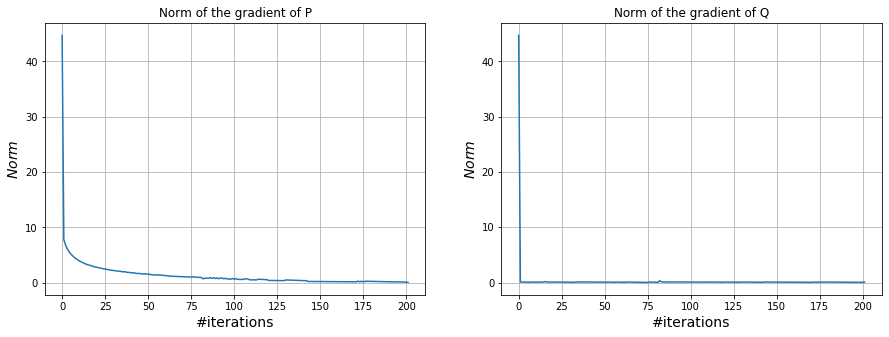

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(list_norm_P)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$Norm$", fontsize=14)
plt.title('Norm of the gradient of P')
plt.grid(True)


plt.subplot(122)
plt.plot(list_norm_Q)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("$Norm$", fontsize=14)
plt.title('Norm of the gradient of Q')
plt.grid(True)
plt.show()

In [10]:
relative_error = np.linalg.norm(data - np.dot(Q, P)) / np.linalg.norm(data) * 100

print("относительная ошибка : %f"%relative_error)

относительная ошибка : 36.358691


Относительная ошибка довольна велика, но в качеств грубого предсказания ее использовать можно.
Т.к. данная модель обучалась на зашумленных данных использовать ее для фильтрации шума нецелесообразно

In [11]:
data_result = Q.dot(P)
print(data_result)
print(data)

[[ 8.09679389e-01  8.33169859e-02  1.25039904e-01 ...  9.65572876e-04
   1.07267339e-02  1.83995350e-03]
 [ 2.33137719e-01  7.62705465e-02  6.47559654e-02 ... -1.01242100e-03
  -5.52198386e-04 -3.31671416e-03]
 [ 7.62407046e-01  9.17891589e-02  1.24843599e-01 ...  1.93610613e-03
   1.25051309e-02  2.69286862e-03]
 ...
 [-8.33898377e-03  2.57109061e-03  1.07549592e-02 ...  2.03898345e-03
   1.82200620e-02  4.62693928e-03]
 [-2.37585660e-03  6.95269185e-03  3.31593464e-03 ...  2.03108206e-04
   9.33167788e-05 -7.03489478e-06]
 [ 1.60429349e-03  7.33762123e-04  5.28019719e-04 ...  1.72015576e-04
   6.58291700e-04  2.92180847e-04]]
[[0.842713  0.171253  0.228401  ... 0.        0.        0.       ]
 [0.213799  0.0453138 0.        ... 0.        0.        0.       ]
 [0.791006  0.160917  0.105361  ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.143809  0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.

In [12]:
print(data_result[0])
print(data[0])

[ 8.09679389e-01  8.33169859e-02  1.25039904e-01  2.37230477e-02
  1.73817339e-02  1.53815596e-02  2.51659974e-04  5.76192918e-02
  7.88010826e-02  7.86086607e-02  5.04992723e-02  4.77684238e-02
  4.43773208e-03 -9.32618558e-04  7.70160736e-03  5.79937850e-02
  6.97888579e-02  5.76034474e-02  1.31646231e-01  6.78073028e-03
  5.62601069e-03  4.46894907e-03 -3.18372870e-03  3.32777292e-04
  1.19573464e-03  1.72195449e-03  3.05889933e-04  2.31790530e-03
  4.85474411e-03  3.18320064e-02  3.23738237e-03  1.73099877e-02
  2.07971994e-02 -7.63904890e-04  8.78094060e-03  7.76214735e-02
  1.54699741e-03 -6.00337178e-05  2.72105840e-02  3.53121227e-03
  7.86337764e-04  6.96943507e-02  1.22176583e-03  1.54180174e-03
  9.38467485e-04  5.18584864e-03  2.85805786e-01  8.12182857e-01
  1.15002680e-03  1.78004843e-03 -3.78329131e-04  5.41043128e-05
  2.68476874e-02  2.00717467e-02  1.26949898e-02  3.12813091e-03
  2.28596455e-03  4.85590890e-03  2.60543025e-02  2.23101536e-02
  8.00681437e-03  6.27501